In [1]:
%matplotlib inline

In [2]:
import os, sys
import nibabel as nb
import numpy as np

from nipype import Node, Workflow
from nipype.interfaces.fsl import SliceTimer, MCFLIRT, Smooth, ExtractROI

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.utils import shuffle

import glob
import shutil

In [3]:
def writer(MyList, tgtf):
    MyFile=open(tgtf,'w')
    MyList=map(lambda x:x+'\n', MyList)
    MyFile.writelines(MyList)
    MyFile.close()

def f_kendall(timeseries_matrix):

    """
    Calculates the Kendall's coefficient of concordance for a number of
    time-series in the input matrix
    Parameters
    ----------
    timeseries_matrix : ndarray
        A matrix of ranks of a subset subject's brain voxels
    Returns
    -------
    kcc : float
        Kendall's coefficient of concordance on the given input matrix
    """

    import numpy as np
    nk = timeseries_matrix.shape

    n = nk[0]
    k = nk[1]

    sr = np.sum(timeseries_matrix, 1)
    sr_bar = np.mean(sr)
    s = np.sum(np.power(sr, 2)) - n*np.power(sr_bar, 2)
    kcc = 12 *s/np.power(k, 2)/(np.power(n, 3) - n)
    return kcc

def compute_reho(in_file, mask_file, cluster_size = 7, out_file = None):

    """
    Computes the ReHo Map, by computing tied ranks of the timepoints,
    followed by computing Kendall's coefficient concordance(KCC) of a
    timeseries with its neighbours
    Parameters
    ----------
    in_file : nifti file
        4D EPI File
    mask_file : nifti file
        Mask of the EPI File(Only Compute ReHo of voxels in the mask)
    out_file : nifti file
        Where to save result
    cluster_size : integer
        for a brain voxel the number of neighbouring brain voxels to use for
        KCC.
    Returns
    -------
    out_file : nifti file
        ReHo map of the input EPI image
    """

    res_fname = (in_file)
    res_mask_fname = (mask_file)
    CUTNUMBER = 10

    if not (cluster_size == 27 or cluster_size == 19 or cluster_size == 7 or cluster_size == 18):
        cluster_size = 27

    nvoxel = cluster_size

    res_img = nb.load(res_fname)
    res_mask_img = nb.load(res_mask_fname)

    res_data = res_img.get_data()
    res_mask_data = res_mask_img.get_data()

    print(res_data.shape)
    (n_x, n_y, n_z, n_t) = res_data.shape

    # "flatten" each volume of the timeseries into one big array instead of
    # x,y,z - produces (timepoints, N voxels) shaped data array
    res_data = np.reshape(res_data, (n_x*n_y*n_z, n_t), order='F').T

    # create a blank array of zeroes of size n_voxels, one for each time point
    Ranks_res_data = np.tile((np.zeros((1, (res_data.shape)[1]))),
                             [(res_data.shape)[0], 1])

    # divide the number of total voxels by the cutnumber (set to 10)
    # ex. end up with a number in the thousands if there are tens of thousands
    # of voxels
    segment_length = np.ceil(float((res_data.shape)[1])/float(CUTNUMBER))

    for icut in range(0, CUTNUMBER):

        segment = None

        # create a Numpy array of evenly spaced values from the segment
        # starting point up until the segment_length integer
        if not (icut == (CUTNUMBER - 1)):
            segment = np.array(np.arange(icut * segment_length,
                                         (icut+1) * segment_length))
        else:
            segment = np.array(np.arange(icut * segment_length,
                                         (res_data.shape[1])))

        segment = np.int64(segment[np.newaxis])

        # res_data_piece is a chunk of the original timeseries in_file, but
        # aligned with the current segment index spacing
        res_data_piece = res_data[:, segment[0]]
        nvoxels_piece = res_data_piece.shape[1]

        # run a merge sort across the time axis, re-ordering the flattened
        # volume voxel arrays
        res_data_sorted = np.sort(res_data_piece, 0, kind='mergesort')
        sort_index = np.argsort(res_data_piece, axis=0, kind='mergesort')

        # subtract each volume from each other
        db = np.diff(res_data_sorted, 1, 0)

        # convert any zero voxels into "True" flag
        db = db == 0

        # return an n_voxel (n voxels within the current segment) sized array
        # of values, each value being the sum total of TRUE values in "db"
        sumdb = np.sum(db, 0)

        temp_array = np.array(np.arange(0, n_t))
        temp_array = temp_array[:, np.newaxis]

        sorted_ranks = np.tile(temp_array, [1, nvoxels_piece])

        if np.any(sumdb[:]):

            tie_adjust_index = np.flatnonzero(sumdb)

            for i in range(0, len(tie_adjust_index)):

                ranks = sorted_ranks[:, tie_adjust_index[i]]

                ties = db[:, tie_adjust_index[i]]

                tieloc = np.append(np.flatnonzero(ties), n_t + 2)
                maxties = len(tieloc)
                tiecount = 0

                while(tiecount < maxties -1):
                    tiestart = tieloc[tiecount]
                    ntied = 2
                    while(tieloc[tiecount + 1] == (tieloc[tiecount] + 1)):
                        tiecount += 1
                        ntied += 1

                    ranks[tiestart:tiestart + ntied] = np.ceil(np.float32(np.sum(ranks[tiestart:tiestart + ntied ]))/np.float32(ntied))
                    tiecount += 1

                sorted_ranks[:, tie_adjust_index[i]] = ranks

        del db, sumdb
        sort_index_base = np.tile(np.multiply(np.arange(0, nvoxels_piece), n_t), [n_t, 1])
        sort_index += sort_index_base
        del sort_index_base

        ranks_piece = np.zeros((n_t, nvoxels_piece))

        ranks_piece = ranks_piece.flatten(order='F')
        sort_index = sort_index.flatten(order='F')
        sorted_ranks = sorted_ranks.flatten(order='F')

        ranks_piece[sort_index] = np.array(sorted_ranks)

        ranks_piece = np.reshape(ranks_piece, (n_t, nvoxels_piece), order='F')

        del sort_index, sorted_ranks

        Ranks_res_data[:, segment[0]] = ranks_piece

        sys.stdout.write('.')

    Ranks_res_data = np.reshape(Ranks_res_data, (n_t, n_x, n_y, n_z), order='F')

    K = np.zeros((n_x, n_y, n_z))

    mask_cluster = np.ones((3, 3, 3))

    if nvoxel == 19:
        mask_cluster[0, 0, 0] = 0
        mask_cluster[0, 2, 0] = 0
        mask_cluster[2, 0, 0] = 0
        mask_cluster[2, 2, 0] = 0
        mask_cluster[0, 0, 2] = 0
        mask_cluster[0, 2, 2] = 0
        mask_cluster[2, 0, 2] = 0
        mask_cluster[2, 2, 2] = 0
        
    elif nvoxel == 18:
        # null mid disk and disky-shaped
        mask_cluster[0, 0, 0] = 0
        mask_cluster[0, 2, 0] = 0
        mask_cluster[2, 0, 0] = 0
        mask_cluster[2, 2, 0] = 0
        mask_cluster[0, 0, 2] = 0
        mask_cluster[0, 2, 2] = 0
        mask_cluster[2, 0, 2] = 0
        mask_cluster[2, 2, 2] = 0
        mask_cluster[1, 0, 0] = 0
        mask_cluster[1, 0, 1] = 0
        mask_cluster[1, 0, 2] = 0
        mask_cluster[1, 2, 0] = 0
        mask_cluster[1, 2, 1] = 0
        mask_cluster[1, 2, 2] = 0
        mask_cluster[1, 1, 0] = 0
        mask_cluster[1, 1, 2] = 0

    elif nvoxel == 7:

        mask_cluster[0, 0, 0] = 0
        mask_cluster[0, 1, 0] = 0
        mask_cluster[0, 2, 0] = 0
        mask_cluster[0, 0, 1] = 0
        mask_cluster[0, 2, 1] = 0
        mask_cluster[0, 0, 2] = 0
        mask_cluster[0, 1, 2] = 0
        mask_cluster[0, 2, 2] = 0
        mask_cluster[1, 0, 0] = 0
        mask_cluster[1, 2, 0] = 0
        mask_cluster[1, 0, 2] = 0
        mask_cluster[1, 2, 2] = 0
        mask_cluster[2, 0, 0] = 0
        mask_cluster[2, 1, 0] = 0
        mask_cluster[2, 2, 0] = 0
        mask_cluster[2, 0, 1] = 0
        mask_cluster[2, 2, 1] = 0
        mask_cluster[2, 0, 2] = 0
        mask_cluster[2, 1, 2] = 0
        mask_cluster[2, 2, 2] = 0

    for i in range(1, n_x - 1):
        for j in range(1, n_y -1):
            for k in range(1, n_z -1):

                block = Ranks_res_data[:, i-1:i+2, j-1:j+2, k-1:k+2]
                mask_block = res_mask_data[i-1:i+2, j-1:j+2, k-1:k+2]

                if not(int(mask_block[1, 1, 1]) == 0):

                    if nvoxel == 19 or nvoxel == 7 or nvoxel == 18:
                        mask_block = np.multiply(mask_block, mask_cluster)

                    R_block = np.reshape(block, (block.shape[0], 27),
                                         order='F')
                    mask_R_block = R_block[:, np.argwhere(np.reshape(mask_block, (1, 27), order='F') > 0)[:, 1]]

                    K[i, j, k] = f_kendall(mask_R_block)

    img = nb.Nifti1Image(K, header=res_img.get_header(),
                         affine=res_img.get_affine())
    
    if out_file is not None:
        reho_file = out_file
    else:
        reho_file = os.path.join(os.getcwd(), 'ReHo.nii.gz')
    img.to_filename(reho_file)
    
    return reho_file

In [4]:
base = "/Volumes/G_drive/Backup_06062020/ds000172/"
order_path = base + "/SlTi/"

sbjpatt  = "control"
sess     = "func"
fmriname = "task-rest_acq-voxelsize333_bold.nii.gz"

In [5]:
TR    = 3.0
fwhm  = 3
dummy = 10
n_sl  = 35
rh    = 18 #27

In [6]:
# https://en.wikibooks.org/wiki/SPM/Slice_Timing

# seq asc 1 2 3 4
slice_order = list(np.arange(1, n_sl+1).astype(str))
writer(slice_order, order_path + 'slti_1.txt') 

# seq desc 4 3 2 1
slice_order = list(reversed(list(np.arange(1, n_sl+1).astype(str))))
writer(slice_order, order_path + 'slti_2.txt') 

# int asc 1 3 2 4
slice_order = list(np.arange(1, n_sl+1, 2).astype(str)) + list(np.arange(2, n_sl+1, 2).astype(str))
writer(slice_order, order_path + 'slti_3.txt') 

# int desc 4 2 3 1
slice_order = list(reversed(list(np.arange(1, n_sl+1, 2).astype(str)) + list(np.arange(2, n_sl+1, 2).astype(str))))
writer(slice_order, order_path + 'slti_4.txt') 

# int2 asc 2 4 1 3
slice_order = list(np.arange(2, n_sl+1, 2).astype(str)) + list(np.arange(1, n_sl+1, 2).astype(str))
writer(slice_order, order_path + 'slti_5.txt') 

# int2 dsc 3 1 4 2
slice_order = list(reversed(list(np.arange(2, n_sl+1, 2).astype(str)) + list(np.arange(1, n_sl+1, 2).astype(str))))
writer(slice_order, order_path + 'slti_6.txt') 

n_last = 12 # how many "noise" permutation to use
for rr in np.arange(7,n_last):
    slice_order = list(shuffle(np.arange(1, n_sl+1).astype(str), random_state=rr))
    writer(slice_order, order_path + 'slti_{}.txt'.format(rr)) # random permutation of slices   

In [ ]:
rehos = []
for sbj in sorted([sbj.split("/")[-1].replace("sub-","") for sbj in glob.glob(base + "sub-{}*".format(sbjpatt))]):
    fmri_nii = base + "sub-{}/{}/".format(sbj,sess) + "sub-{}{}".format(sbj,fmriname)
    for opt in np.arange(1, n_last):
        #if (opt in [5,6] and n_sl%2==0): 
            # skip Siemens interleaved even cases unless n_sl is really even
        
        proc_ref   = '{}_preproc_{}'.format(sbj,opt)
        extract    = Node(ExtractROI(t_min=dummy, t_size=-1, output_type='NIFTI_GZ'), name="extract")
        slicetimer = Node(SliceTimer(custom_order = order_path + "slti_{}.txt".format(opt), time_repetition=TR), name="slicetimer")
        mcflirt    = Node(MCFLIRT(mean_vol=True, save_plots=True), name="mcflirt")
        smooth     = Node(Smooth(fwhm=fwhm), name="smooth")
        preproc01  = Workflow(name=proc_ref, base_dir=base)
        preproc01.connect([(extract,    slicetimer, [('roi_file', 'in_file')]),
                           (slicetimer, mcflirt,    [('slice_time_corrected_file', 'in_file')]),
                           (mcflirt,    smooth,     [('out_file', 'in_file')])])
        extract.inputs.in_file = fmri_nii
        preproc01.run('MultiProc', plugin_args={'n_procs': 1})
        
        basepath = base + "/{}/smooth/".format(proc_ref)
        proc_f   = basepath + fmri_nii.split("/")[-1].replace(".nii.gz","") + "_roi_st_mcf_smooth.nii.gz"
        in_f     = basepath + "meanvol"
        out_f    = basepath + "meanvol_bet"
        !fslmaths {proc_f} -Tmean {in_f}
        !bet {in_f} {out_f} -m
        
        rehos.append([sbj, opt, compute_reho(proc_f, in_f + "_bet" + "_mask.nii.gz", rh, out_file = base + "/" + sbj + "_" + str(opt) + "_ReHo.nii.gz")])
        shutil.rmtree(base + "/{}/".format(proc_ref))

In [45]:
rehos = [[ff.split("/")[-1].split("_")[0], ff.split("/")[-1].split("_")[1], ff] for ff in glob.glob(base+"*_ReHo.nii.gz")]

In [46]:
thr = 0.05
res = pd.DataFrame(columns=['sbj', 'ord', 'rehoavg', 'rehopct'])
for nii in rehos:
    img = nb.load(nii[-1]).get_fdata()
    img = img.ravel()
    img = img[img>thr]    
    if int(nii[1]) < 7:
        res = res.append({"sbj":nii[0], "ord":nii[1], "rehoavg":np.nanmean(img), "rehopct":np.percentile(img,90)}, ignore_index = True)
    else:
        res = res.append({"sbj":nii[0], "ord":"0",      "rehoavg":np.nanmean(img), "rehopct":np.percentile(img,90)}, ignore_index = True)

In [47]:
metric = "rehopct"

signif = pd.DataFrame(columns=['sbj', 'ord', 'reho', 'tt'])
for sbj in np.unique(res.sbj.values):
    rsel = res[res.sbj == sbj].sort_values(["rehopct","rehoavg"])
    
    for oo in np.arange(0,7):
        oo = str(oo)
        t2 = (np.nanmean(rsel[rsel.ord == oo][metric].values - np.nanmean(rsel[rsel.ord == "0"][metric].values))) / \
            np.nanstd(rsel[rsel.ord == "0"][metric].values)
        signif = signif.append({"sbj":sbj, 
                                "ord":oo, 
                                "reho":round(np.nanmean(rsel[rsel.ord == oo][metric].values),3), 
                                "tt": round(np.abs(t2), 3)}, ignore_index = True)

signif = signif[(signif.ord != "5") & (signif.ord != "6")] # exclude impossible cases

lls = []
for sbj in np.unique(res.sbj.values):
    rsel = signif[signif.sbj == sbj].sort_values(["reho","sbj"])
    lls.append(rsel[rsel.sbj==sbj].iloc[-1:].ord.values[:])

In [48]:
x  = np.array(lls).astype(int).ravel()
y  = np.bincount(x)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[ 1,  1],
       [ 3, 11]])

In [49]:
signif.sort_values(["sbj", "tt"]).head(10)

,sbj,ord,reho,tt
0,control01,0,0.495,0.000
2,control01,2,0.498,0.582
1,control01,1,0.499,0.621
3,control01,3,0.511,2.501
4,control01,4,0.475,3.058
7,control02,0,0.436,0.000
8,control02,1,0.442,1.031
9,control02,2,0.445,1.534
11,control02,4,0.418,2.815
10,control02,3,0.454,3.056


In [24]:
SliceTimingGT = [
      0.0, 
      1.54286, 
      0.08571, 
      1.62857, 
      0.17143, 
      1.71429, 
      0.25714, 
      1.8, 
      0.34286, 
      1.88571, 
      0.42857, 
      1.97143, 
      0.51429, 
      2.05714, 
      0.6, 
      2.14286, 
      0.68571, 
      2.22857, 
      0.77143, 
      2.31429, 
      0.85714, 
      2.4, 
      0.94286, 
      2.48571, 
      1.02857, 
      2.57143, 
      1.11429, 
      2.65714, 
      1.2, 
      2.74286, 
      1.28571, 
      2.82857, 
      1.37143, 
      2.91429, 
      1.45714
   ]

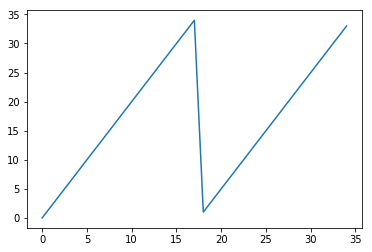

In [26]:
plt.plot(np.argsort(SliceTimingGT)) # consistent with option 3